In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('src/')

import csv
from utils import DEFAULT_PALETTE
from WADParser import open_wad_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy

In [2]:
w = open_wad_file('WADs/DOOM.WAD')

2025-03-10 17:33:36.764 | INFO     | WADParser:__init__:40 - Found a DOOM IWAD.
2025-03-10 17:33:36.774 | INFO     | WADParser:_get_palette:126 - Palette extracted.
2025-03-10 17:33:36.779 | INFO     | WADParser:_parse_levels:166 - 36 levels found in this WAD.
2025-03-10 17:33:36.780 | INFO     | WADParser:_parse_by_markers:196 - 107 FLATS found in this WAD.
2025-03-10 17:33:36.781 | INFO     | WADParser:_parse_by_markers:196 - 764 SPRITES found in this WAD.
2025-03-10 17:33:36.799 | INFO     | WADParser:_parse_things:138 - DOOM THINGS loaded.
2025-03-10 17:33:36.810 | INFO     | WADParser:_gather_textures:367 - Parsed 125 textures.


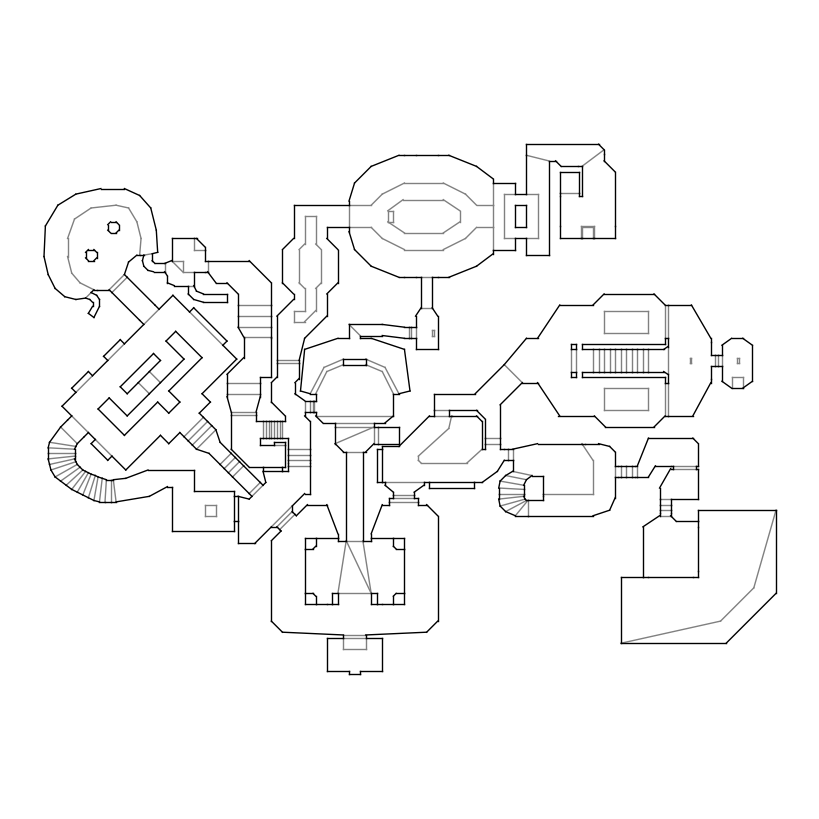

In [3]:
map_infos = w.map('E1M3')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for line in map_infos['steps']:
        ax.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)

for line in map_infos['walls']:
        ax.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

ax.axis('off')
ax.axis('equal')
fig.tight_layout(pad=0)     

In [4]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

NameError: name 'linedefs' is not defined

In [ ]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
d2 = d.copy()
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        save_vertex = d2.get(start, None)

        if (next_vertex is None) & (save_vertex is None):
            break
        elif (next_vertex is None) & (save_vertex is not None):
            line.append(save_vertex)
            break

        line.append(next_vertex)
        start = next_vertex
    lines.append(line)


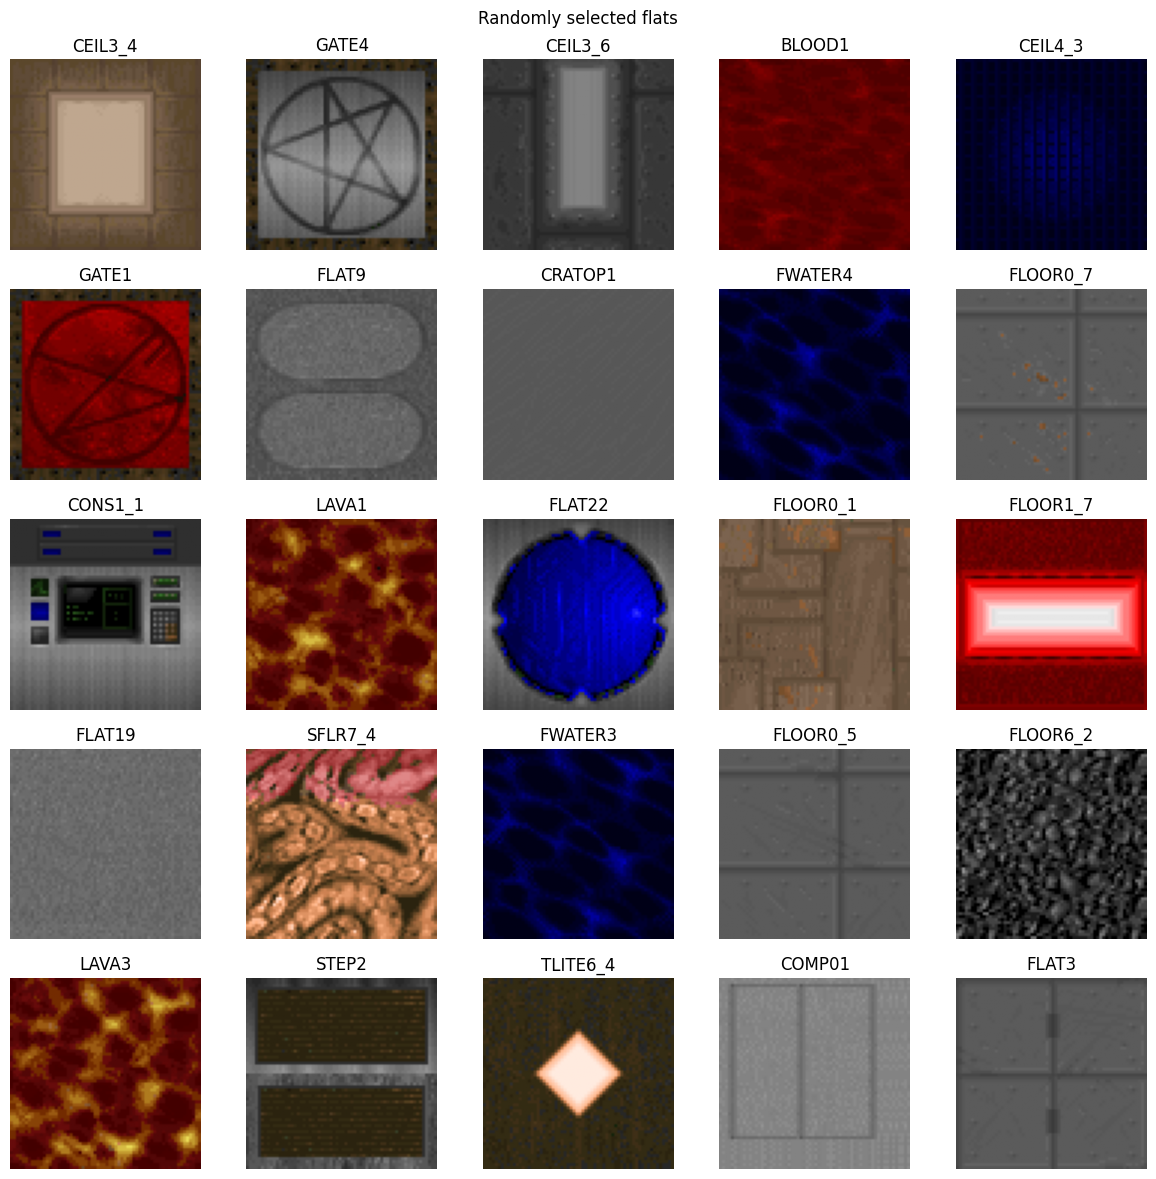

In [5]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

In [6]:
def parse_patches(w):
    lump = w._lump_data_by_name('PNAMES')

    n_patches = int.from_bytes(lump[0:4], byteorder='little')
    patches = []
    for i in range(n_patches):
        patch_name = lump[4 + i * 8: 4 + (i + 1) * 8].decode('ascii').rstrip('\0')
        patches.append(patch_name)
    return patches

def parse_textures(w, lump_names, patches):
    textures = {}
    for lump_name in lump_names:

        lump_id = w.lump_names.index(lump_name)
        _, lump_offset, size = w.lumps[lump_id]

        w.wad.seek(lump_offset)
        texture1_data = w.wad.read(size)

        numtextures = int.from_bytes(texture1_data[0:4], byteorder='little')
        w.wad.seek(lump_offset + 4)

        textures_offsets = []
        for i in range(numtextures):
            offset = int.from_bytes(w.wad.read(4), byteorder='little')
            textures_offsets.append(offset)

        for tx_offset in textures_offsets:
            w.wad.seek(lump_offset + tx_offset)
            texture_name = w.wad.read(8).decode('ascii').rstrip('\0')

            mask, width, height, col_dir = struct.unpack("<ihhi", w.wad.read(12))

            patch_count = int.from_bytes(w.wad.read(2), byteorder='little')
            map_patches = np.array([struct.unpack("<hhhhh", w.wad.read(10)) for i in range(patch_count)])

            orig_x = map_patches[:, 0]
            orig_y = map_patches[:, 1]
            patch_idxs = map_patches[:, 2]

            patch_infos = [(patches[patch_idxs[i]], int(orig_x[i]), int(orig_y[i])) for i in range(patch_count)]           
            textures[texture_name] = {'width': width, 'height': height, 'patches': patch_infos}

    return textures

patches = parse_patches(w)

lump_names=['TEXTURE1', 'TEXTURE2']
textures = parse_textures(w, lump_names, patches)

textures

{'AASTINKY': {'width': 24,
  'height': 72,
  'patches': [('WALL00_3', 0, 0), ('WALL00_3', 12, -6)]},
 'BIGDOOR1': {'width': 128,
  'height': 96,
  'patches': [('W13_1', 0, 0),
   ('W13_1', 0, 24),
   ('DOOR2_1', 17, 0),
   ('W13_1', 113, 0),
   ('W13_1', 113, 25)]},
 'BIGDOOR2': {'width': 128, 'height': 128, 'patches': [('DOOR2_4', 0, 0)]},
 'BIGDOOR4': {'width': 128, 'height': 128, 'patches': [('DOOR9_1', 0, 0)]},
 'BRNBIGC': {'width': 128, 'height': 128, 'patches': [('W113_1', 0, 0)]},
 'BRNBIGL': {'width': 32, 'height': 128, 'patches': [('W113_2', 0, 0)]},
 'BRNBIGR': {'width': 32, 'height': 128, 'patches': [('W113_3', 0, 0)]},
 'BRNPOIS': {'width': 64,
  'height': 128,
  'patches': [('WALL62_2', 0, 0), ('PS20A0', 1, 60)]},
 'BRNPOIS2': {'width': 64,
  'height': 128,
  'patches': [('WALL62_1', 0, 0), ('PS20A0', 0, 57)]},
 'BRNSMAL1': {'width': 64, 'height': 64, 'patches': [('W111_2', 0, 0)]},
 'BRNSMAL2': {'width': 64, 'height': 64, 'patches': [('W111_3', 0, 0)]},
 'BRNSMALC': {'wid

In [7]:
def paste_array(original, paste, x, y):
    """
    Pastes a 2D numpy array into another 2D numpy array at the specified (x, y) position.
    Allows for negative x and y values.
    I miss Labview paste-and-forget function :'(
    """
    orig_h, orig_w = original.shape
    paste_h, paste_w = paste.shape
    
    # Valid region in the original array
    x_start = max(x, 0)
    y_start = max(y, 0)
    x_end = min(x + paste_w, orig_w)
    y_end = min(y + paste_h, orig_h)
    
    # Corresponding region in the paste array
    paste_x_start = max(-x, 0)
    paste_y_start = max(-y, 0)
    paste_x_end = paste_x_start + (x_end - x_start)
    paste_y_end = paste_y_start + (y_end - y_start)
        
    original[y_start:y_end, x_start:x_end] = paste[paste_y_start:paste_y_end, paste_x_start:paste_x_end]
    
    return original


{'width': 24, 'height': 72, 'patches': [('WALL00_3', 0, 0), ('WALL00_3', 12, -6)]}


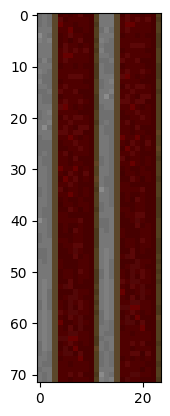

In [10]:
texture = 'AASTINKY'

texture_data = textures[texture]
pix_width, pix_height = texture_data['width'], texture_data['height']

print(texture_data)

pixmap = np.zeros((pix_width, pix_height), dtype=np.uint8)
alphamap = np.zeros((pix_width, pix_height), dtype=np.uint8)
for patch_name, x, y in texture_data['patches']:

    idx = w.lump_names.index(patch_name)

    _, offset, size = w.lumps[idx]
    img, alpha, _, _ = w._read_patch_data(offset, size)

    # y and x are flipped as the image will be transposed after
    pixmap = paste_array(pixmap, img, y, x)
    alphamap = paste_array(alphamap, alpha, y, x)

alphamap = alphamap.T[:, :, np.newaxis] * np.ones((1, 1, 4))

rgb_img = w.palette[pixmap.T]

rgba_img = rgb_img * alphamap
plt.imshow(rgba_img / 255)  


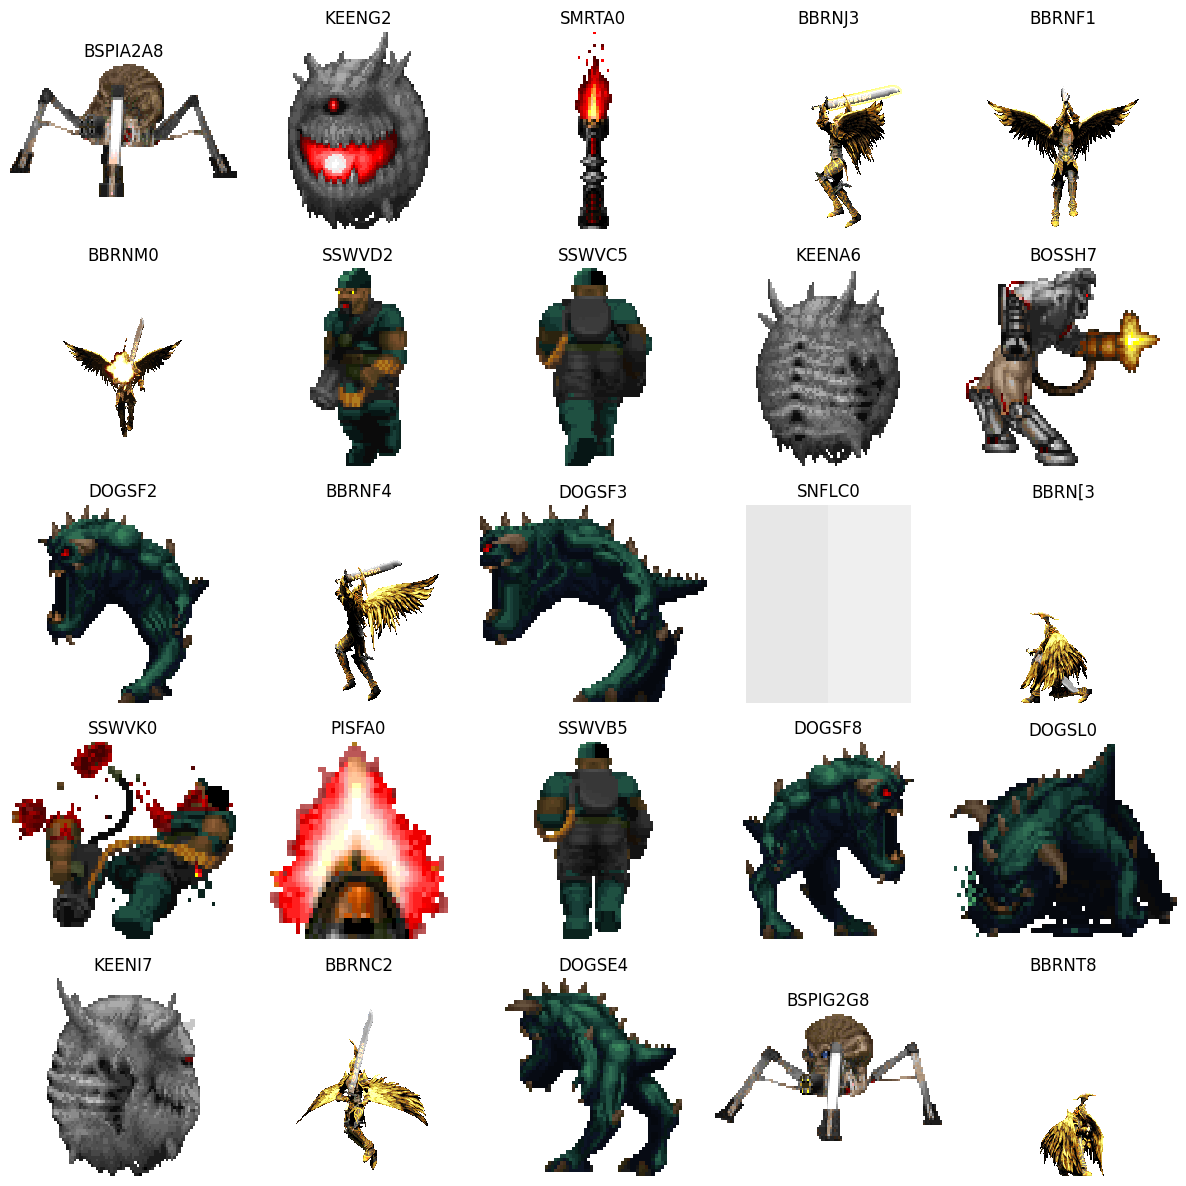

In [ ]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

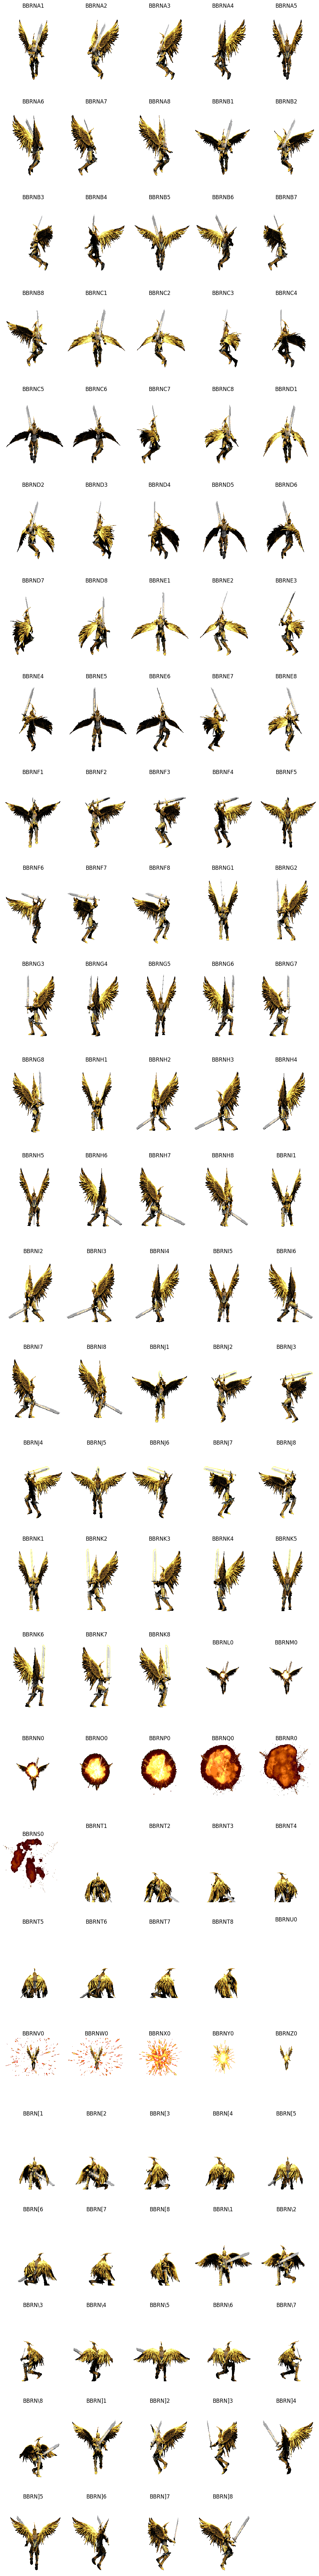

In [ ]:
sprite_name = 'BBRN'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [ ]:
# Example linedefs array (replace this with your actual data)
linedefs = np.array([[1, 2], [2, 3], [3, 4], [4, 1]])

d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0:
        break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

print(lines)

[[1, 2, 3, 4, 1]]
